In [1]:
from skimage import io
from skimage.feature import greycomatrix, greycoprops 
import matplotlib.pyplot as plt
import torch.fft
import torch 

from itertools import product
import numpy as np

torch.set_printoptions(edgeitems=3)

## Loading the Images for analysis 

### Why work with just a bunch of images? 
Here instead of jumping straight into the analysis of thousands of images, I first wanted to explore and hunt for evidences that could test my speculations about the image distributions. 

### Why only these specific ones ?
The images chosen were not a paired set in the dataset, in fact the dataset doesn't even have classes or faces for which their real/fake counterparts exists. Hence it was at my visual discernment of the images that I chose these sets of images. The original dataset that we are working with has a random set of real faces and a random set of deep fake faces.

In [2]:
image = io.imread(r"C:\Users\mistr\OneDrive\Desktop\test.png")

df_1 = io.imread(r"C:\Users\mistr\OneDrive\Desktop\df01604.jpg")
real_1 = io.imread(r"C:\Users\mistr\OneDrive\Desktop\real03611.jpg")

df_2 = io.imread(r"C:\Users\mistr\OneDrive\Desktop\df01608.jpg")
real_2 = io.imread(r"C:\Users\mistr\OneDrive\Desktop\real03601.jpg")


df_3 = io.imread(r"C:\Users\mistr\OneDrive\Desktop\df01617.jpg")
real_3 = io.imread(r"C:\Users\mistr\OneDrive\Desktop\real03612.jpg")

df_4 = io.imread((r"C:\Users\mistr\OneDrive\Desktop\df_4.png"))
real_4 = io.imread((r"C:\Users\mistr\OneDrive\Desktop\real_4.png"))


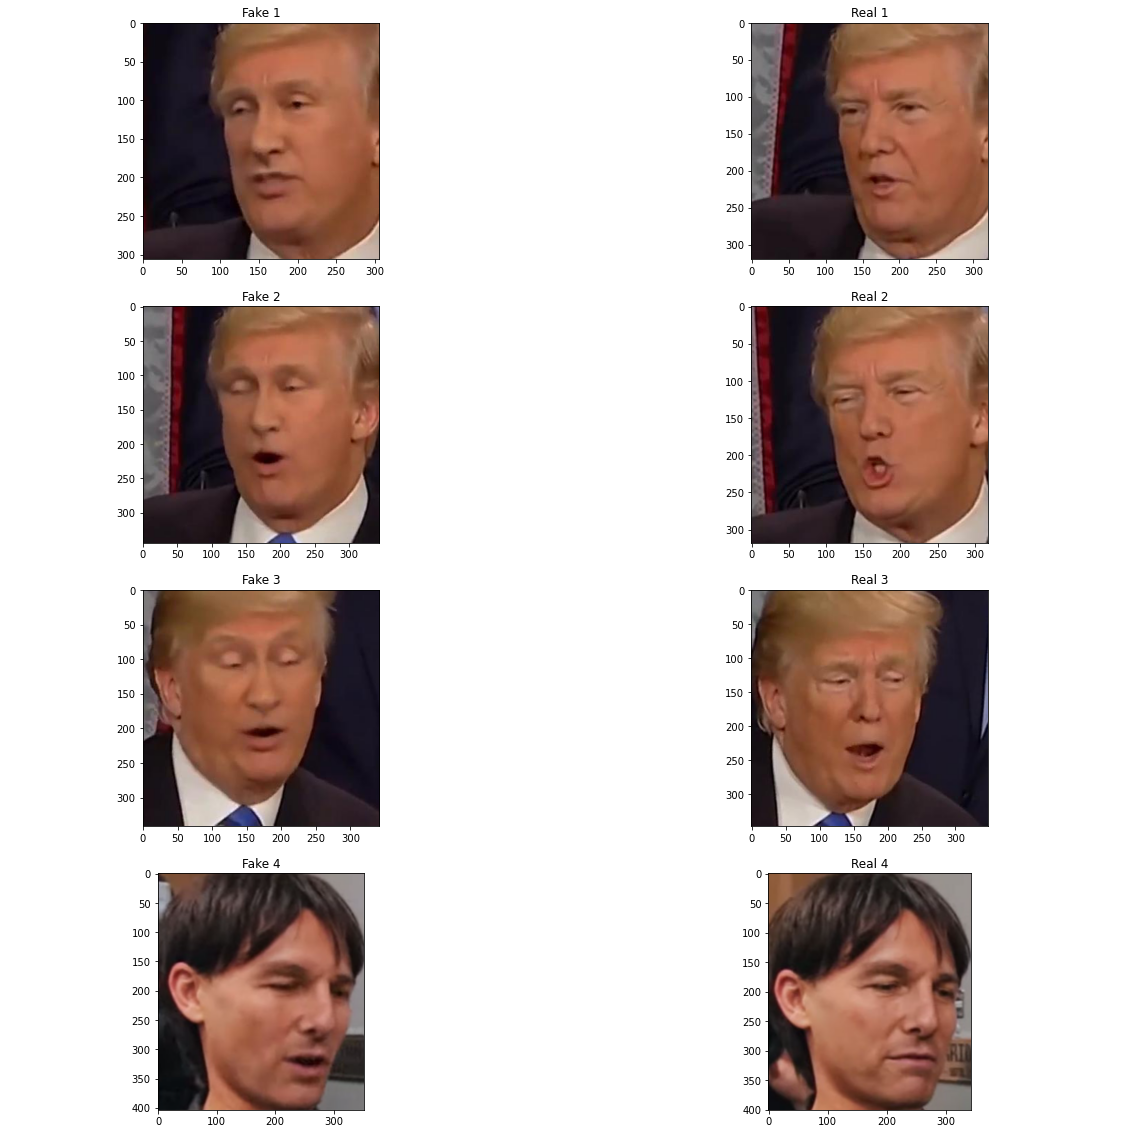

In [3]:
fig, axes = plt.subplots(4, 2, figsize=(20,20))
[axi.set_axis_off() for axi in axes.ravel()]
#setting off the external axis that was from [0:1]
ax1 = fig.add_subplot((421))
ax1.imshow(df_1)
ax1.title.set_text("Fake 1")
ax2 = fig.add_subplot(4, 2, 2)
ax2.imshow(real_1)
ax2.title.set_text("Real 1")
ax3 = fig.add_subplot(4, 2, 3)
ax3.imshow(df_2)
ax3.title.set_text("Fake 2")
ax4 = fig.add_subplot(4, 2, 4)
ax4.imshow(real_2)
ax4.title.set_text("Real 2")
ax5 = fig.add_subplot(4, 2, 5)
ax5.imshow(df_3)
ax5.title.set_text("Fake 3")
ax6 = fig.add_subplot(4, 2, 6)
ax6.imshow(real_3)
ax6.title.set_text("Real 3")
ax7 = fig.add_subplot(4, 2, 7)
ax7.imshow(df_4)
ax7.title.set_text("Fake 4")
ax8 = fig.add_subplot(4, 2, 8)
ax8.imshow(real_4)
ax8.title.set_text("Real 4")


# fig.


### Why lists as data structures ?

It is because in future if I plot many images again each other then can have these in a pandas dataframe or even just a numpy array and then manipluate these easily for the plots which again I have tried my best to keep as modular functions and not individual plots.

In [4]:
# list because in future if I plot many images again each other then can have these in a pandas df and 
# then manipluate these easily for the plots as they are functions now
real_images = [real_1, real_2, real_3, ...]
fake_images = [df_1, df_2, df_3, ...]

## Plotting the histograms for the image pixels

In [5]:
def plot_hist(image, ax=None):
    """
    Just flattens out the image and makes bin plots for the same visualized as an histogram
    
    image (ndarray) : The image whose plots are to be made
    ax (axis) : For the subplots, the axes in which we want to put this particular subplot

    """
    if ax is None:
        ax = plt.gca()
    ax.hist(image.ravel(), bins=256, color="orange",)
#     image.ravel() is basically the flatten function, it form a single line of the np array.

    return ax

In [6]:
def plot_hist_channel(image, channel, ax=None):
    """
    Used to plot the the various colour channels in terms of x in 
    
    image (ndarray) : The image whose plots are to be made
    channel : Used to index the image in the function to get the channel => {0 - Red , 1-Blue, 2-Green}   
    ax (axis) : For the subplots, the axes in which we want to put this particular subplot
    
    """
    if channel == 0:
        colour = 'red'
    if channel ==1:
        colour ='blue'
    if channel ==2:
        colour ='green'
    if ax is None:
        ax = plt.gca()
    ax.hist(image[:, :, channel].ravel(),bins=256, color= colour, alpha=0.5)
    return ax

### Plotting the simple bins for the various pixel values of the image as a whole

Text(0.5, 0.98, 'Bin counts of the pixel values')

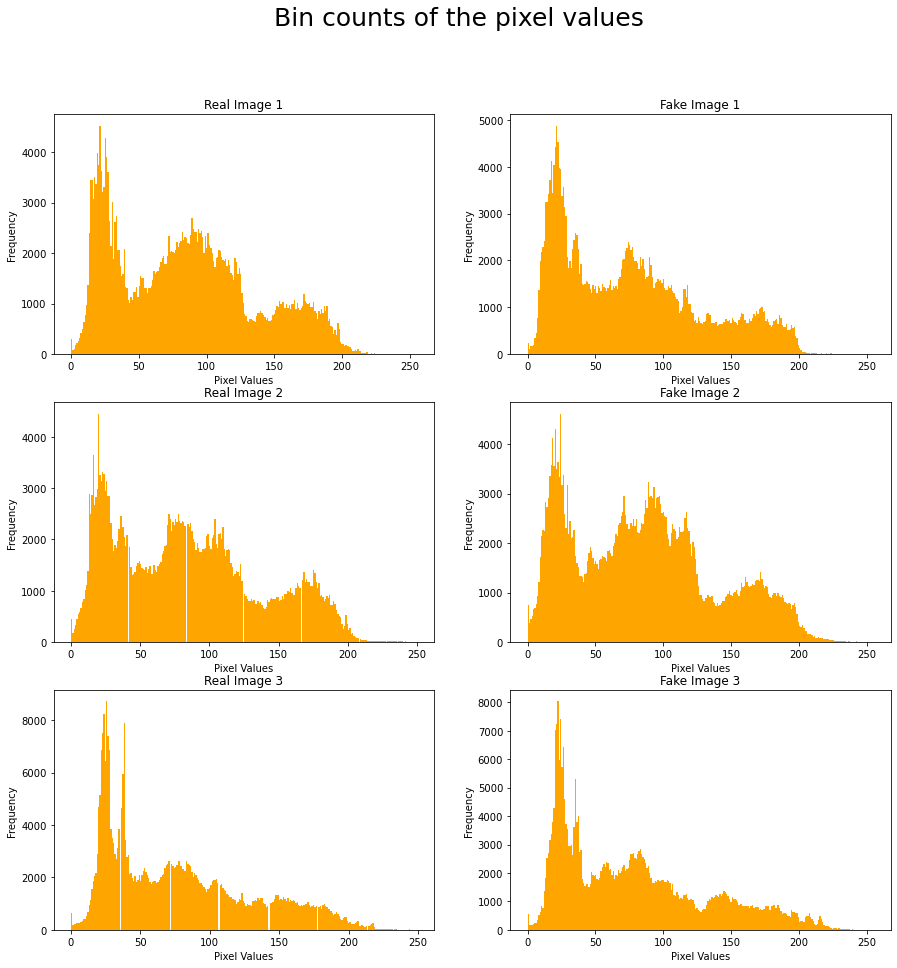

In [7]:
fig_1, axes = plt.subplots(3, 2, figsize=(15, 15))
plot_hist(real_1,  ax=axes[0][0])
axes[0][0].set(ylabel='Frequency', xlabel='Pixel Values', title='Real Image 1')

plot_hist(df_1,  ax=axes[0][1])
axes[0][1].set(ylabel='Frequency', xlabel='Pixel Values', title='Fake Image 1')

plot_hist(real_2,  ax=axes[1][0])
axes[1][0].set(ylabel='Frequency', xlabel='Pixel Values', title='Real Image 2')

plot_hist(df_2,  ax=axes[1][1])
axes[1][1].set(ylabel='Frequency', xlabel='Pixel Values', title='Fake Image 2')

plot_hist(real_3,  ax=axes[2][0])
axes[2][0].set(ylabel='Frequency', xlabel='Pixel Values', title='Real Image 3')

plot_hist(df_3,  ax=axes[2][1])
axes[2][1].set(ylabel='Frequency', xlabel='Pixel Values', title='Fake Image 3')

# plot_hist(real_4,  ax=axes[3][0])
# axes[3][0].set(ylabel='Frequency', xlabel='Pixel Values', title='Real Image 4')

# plot_hist(df_4,  ax=axes[3][1])
# axes[3][1].set(ylabel='Frequency', xlabel='Pixel Values', title='Fake Image 4')

fig_1.suptitle("Bin counts of the pixel values", fontsize=25)

It is difficult to make acute observations from the overall/combined values as the trend is quite similar (nothing unexpected as they are "Deep Fakes"). Although we can observe that there are at times there are discontinuities present int the real images but the texture of the fake images interpolates the same.

### Patterns behave a little different at sep layers

 We now go for a more fine grained approach and try and plot the channel wise distribution of pixels
 Here we will only plot the distribution for one set of images i.e - {real_3, df_3} and as we will see the differences in the patterns become are more prominent. 
 
One observation that could be made is that the frequency of some pixel values is conditionally higher than that of those compared with the real counterpart(All the plots can attest to this).One reason could be the presence of other factors like changes in brightness or contrast values.

Another observation is simply the unexpected rises and dips in the frequency of certain pixel values (green channel plots support this assertion) 

Text(0.5, 0.98, 'Channel wise distn of pixels for Real_3 and Fake_3')

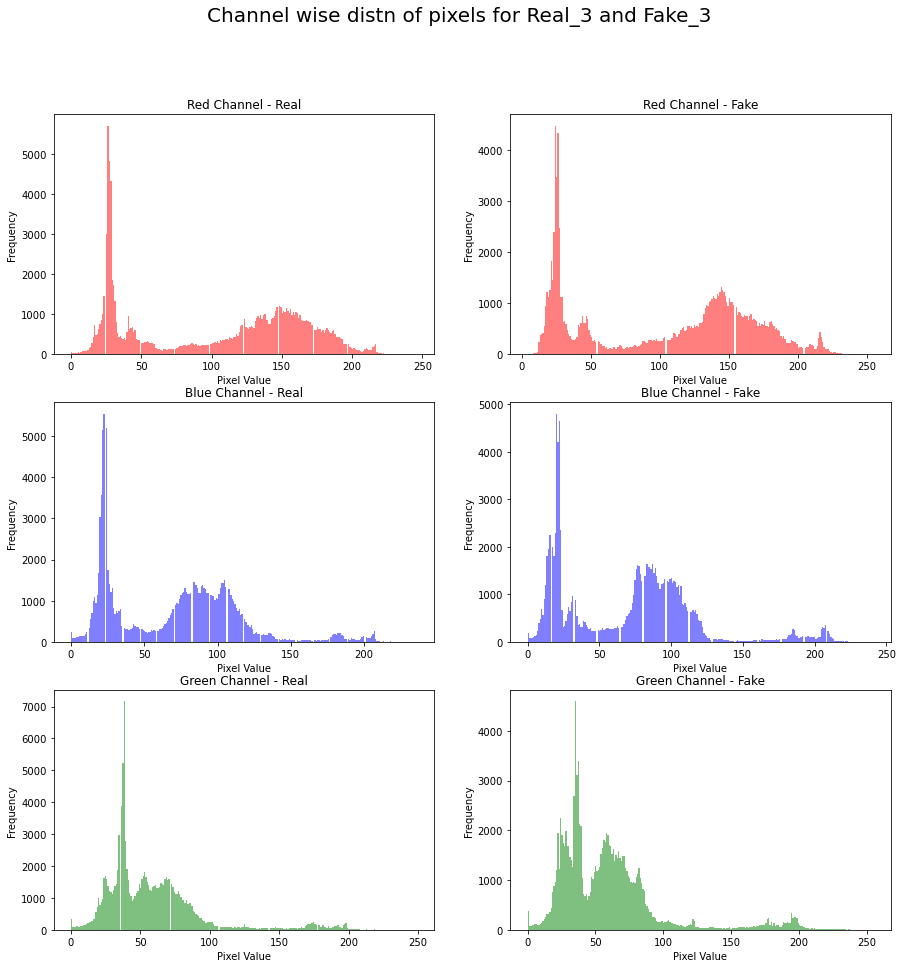

In [8]:
# We noe go a litter more fine grained and try and plot the channel wise distribution of pixels
# Here we will only plot the distribution for one set of images i.e - {real_3, df_3}


fig_1, axes = plt.subplots(3,2, figsize = (15,15))
plot_hist_channel(real_3, 0, ax = axes[0][0])
axes[0][0].set(ylabel = 'Frequency', xlabel = "Pixel Value" , title = "Red Channel - Real")
                         
plot_hist_channel(df_3, 0, ax = axes[0][1])
axes[0][1].set(ylabel = 'Frequency', xlabel = "Pixel Value" , title = "Red Channel - Fake" )

plot_hist_channel(real_3, 1, ax = axes[1][0])
axes[1][0].set(ylabel = 'Frequency', xlabel = "Pixel Value" , title = "Blue Channel - Real" )

plot_hist_channel(df_3, 1, ax = axes[1][1])
axes[1][1].set(ylabel = 'Frequency', xlabel = "Pixel Value" , title = "Blue Channel - Fake" )

plot_hist_channel(real_3, 2, ax = axes[2][0])
axes[2][0].set(ylabel = 'Frequency', xlabel = "Pixel Value" , title = "Green Channel - Real" )

plot_hist_channel(df_3, 2, ax = axes[2][1])
axes[2][1].set(ylabel = 'Frequency', xlabel = "Pixel Value" , title = "Green Channel - Fake" )

fig_1.suptitle("Channel wise distn of pixels for Real_3 and Fake_3", fontsize = 20)

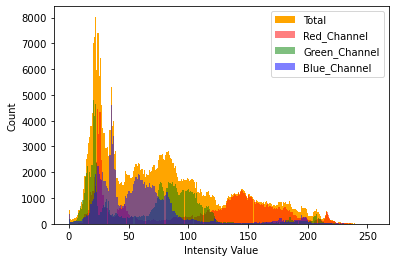

In [9]:

# Just to have an overview of all the hists together for the image df_3
_ = plt.hist(df_3.ravel(), bins = 256, color = 'orange', )
_ = plt.hist(df_3[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(df_3[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(df_3[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

### Another evidence

The difference in the pattern becomes more evident when we run the same tests for another set of images - {df_4, real_4}.

1. The initial observation could be rejected for now as no such pattern observed again for these images
2. The second observation is bolstered by the blue and the green curves as they show significant change in the distribution pattern

Text(0.5, 0.98, 'Channel wise distn of pixels for Real_3 and Fake_3')

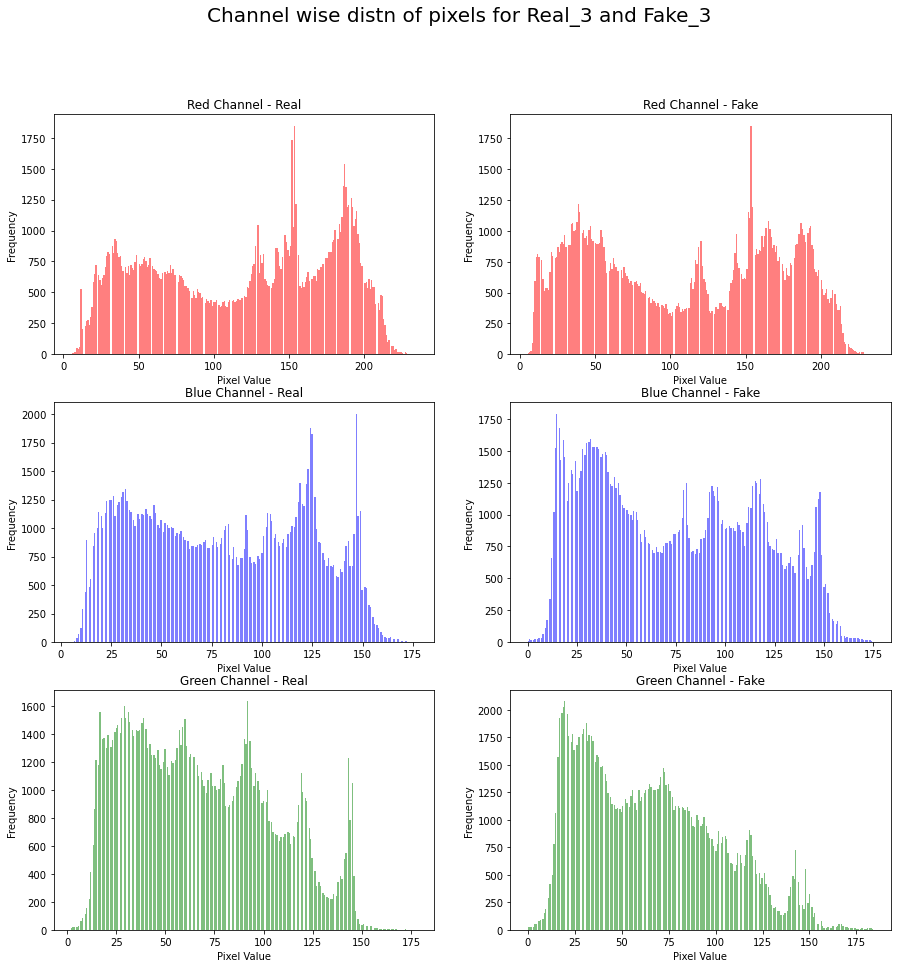

In [10]:

fig_1, axes = plt.subplots(3,2, figsize = (15,15))
plot_hist_channel(real_4, 0, ax = axes[0][0])
axes[0][0].set(ylabel = 'Frequency', xlabel = "Pixel Value" , title = "Red Channel - Real")
                         
plot_hist_channel(df_4, 0, ax = axes[0][1])
axes[0][1].set(ylabel = 'Frequency', xlabel = "Pixel Value" , title = "Red Channel - Fake" )

plot_hist_channel(real_4, 1, ax = axes[1][0])
axes[1][0].set(ylabel = 'Frequency', xlabel = "Pixel Value" , title = "Blue Channel - Real" )

plot_hist_channel(df_4, 1, ax = axes[1][1])
axes[1][1].set(ylabel = 'Frequency', xlabel = "Pixel Value" , title = "Blue Channel - Fake" )

plot_hist_channel(real_4, 2, ax = axes[2][0])
axes[2][0].set(ylabel = 'Frequency', xlabel = "Pixel Value" , title = "Green Channel - Real" )

plot_hist_channel(df_4, 2, ax = axes[2][1])
axes[2][1].set(ylabel = 'Frequency', xlabel = "Pixel Value" , title = "Green Channel - Fake" )

fig_1.suptitle("Channel wise distn of pixels for Real_3 and Fake_3", fontsize = 20)

In [11]:
# def plot_glcm_channel(image, channel, ax=None):
#     if ax is None:
#         ax = plt.gca()
#     ax = imshow(greycomatrix(image, distances=[1], angles=[0,np.pi/4,np.pi/2,3*np.pi/4], levels=256).reshape(512,512))
#     return ax

# fig_3, axes = plt.subplots(3,1, figsize = (15,15))
# plot_glcm_channel(real_3, 0, ax = axes[0][0])
# axes[0][0].set(ylabel = 'Frequency', xlabel = "Pixel Value" , title = "Red Channel - Real")

## Why GLCM? 

As we delve deeper into the regions, I think it would be a good idea to use the various texture information from these images to 
1. Produce more features from the images
2. Understand how the various texture parameters vary across real and deep fake counterparts of the same person 
3. Also see if we can extrapolate a general pattern from the random deep fakes images given in our dataset

In [12]:
def make_GLCM_plot(real_image, fake_image, dist, plot_size = (20,20)):
    """
    Takes as input images and splits the images based on the colour channels and then 
    calculating the GLCM (Gray- Level Co-occurence matrix for each of the layers)
    """
    
    real_image_red  = real_image[:,:,0]
    real_image_blue  = real_image[:,:,1]
    real_image_green  = real_image[:,:,2]
    
    
    fake_image_red = fake_image[:,:,0]
    fake_image_blue = fake_image[:,:,1]
    fake_image_green = fake_image[:,:,2]
   
    glcm_red_real = greycomatrix(real_image_red, distances=[dist], angles=[0,np.pi/4,np.pi/2,3*np.pi/4], levels=256).reshape(512,512)
    glcm_blue_real = greycomatrix(real_image_blue, distances=[dist], angles=[0,np.pi/4,np.pi/2,3*np.pi/4], levels=256).reshape(512,512)
    glcm_green_real = greycomatrix(real_image_green, distances=[dist], angles=[0,np.pi/4,np.pi/2,3*np.pi/4], levels=256).reshape(512,512)

    glcm_red_df = greycomatrix(fake_image_red, distances=[dist], angles=[0,np.pi/4,np.pi/2,3*np.pi/4], levels=256).reshape(512,512)
    glcm_blue_df = greycomatrix(fake_image_blue ,distances=[dist], angles=[0,np.pi/4,np.pi/2,3*np.pi/4], levels=256).reshape(512,512)
    glcm_green_df = greycomatrix(fake_image_green , distances=[dist], angles=[0,np.pi/4,np.pi/2,3*np.pi/4], levels=256).reshape(512,512)



    fig_3, axes = plt.subplots(3,2,figsize = plot_size )

    axes[0][0].imshow(glcm_red_df, cmap = 'turbo'),
    axes[0][0].set(title = "Red Channel - Fake")
    axes[1][0].imshow(glcm_blue_df, cmap = 'turbo'),
    axes[1][0].set(title = "Blue Channel - Fake")
    axes[2][0].imshow(glcm_green_df, cmap = 'turbo'),
    axes[2][0].set(title = "Green Channel - Fake")

    axes[0][1].imshow(glcm_red_real, cmap = 'turbo'),
    axes[0][1].set(title = "Red Channel - Real")
    axes[1][1].imshow(glcm_blue_real, cmap = 'turbo'),
    axes[1][1].set(title = "Blue Channel - Real")
    axes[2][1].imshow(glcm_green_real, cmap = 'turbo'),
    axes[2][1].set(title = "Green Channel - Real")

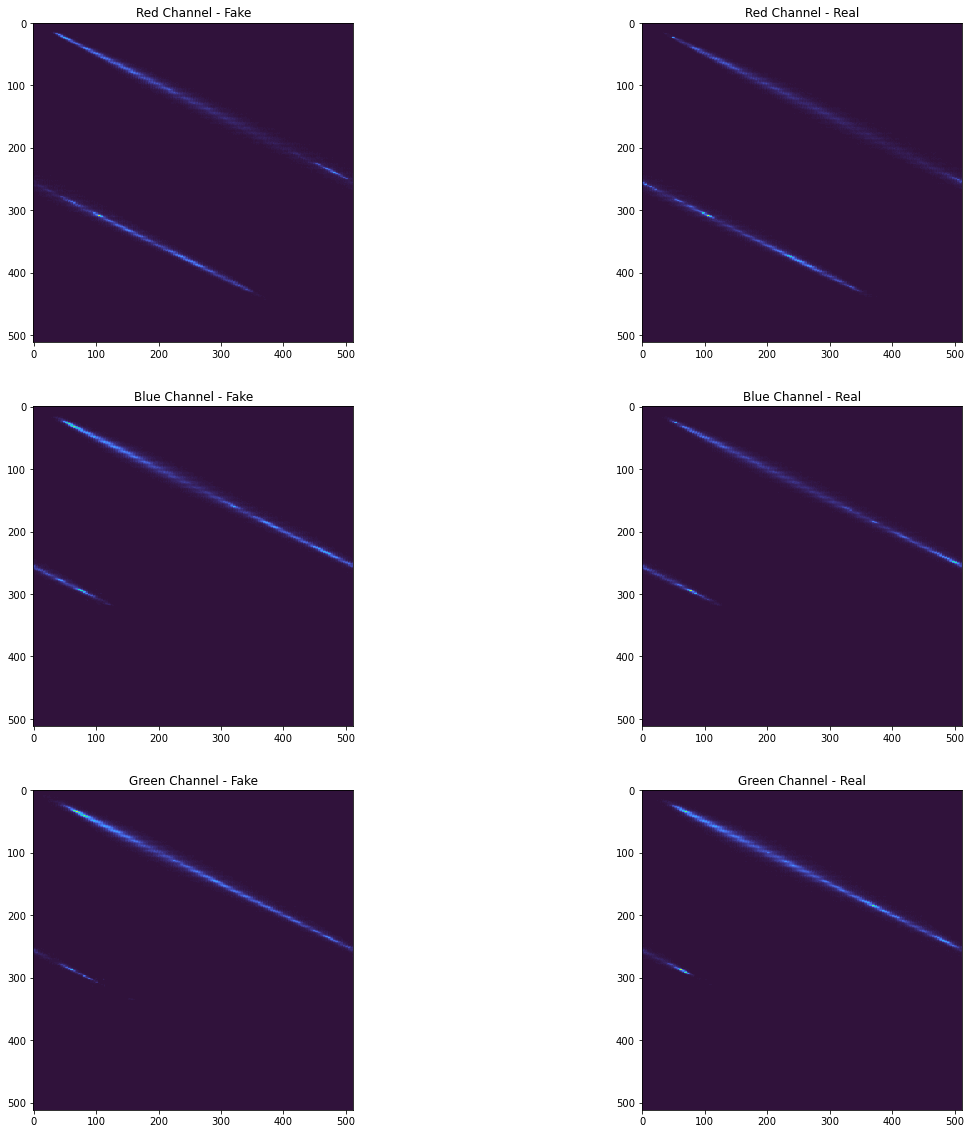

In [13]:
make_GLCM_plot(real_4, df_4, 1)

For this particular set of image : df_4 and real_4 we see that there are possibly some differences in the texture as we keep on testing with various distances - However in our case the closer distances for pixels like (1:5) might not really give any insights as they would be just taking into consideration the ones that are adjacent. It is highly likely that the manipulated images would contain patches of changes made to the image and not just pixels sprinkled over the entire image.  

Lets begin the analysis with the patches from the images : "df_3" first and then later if we can use the gained insights and apply them to "real_3".  

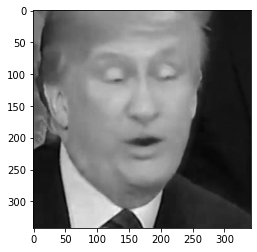

In [14]:
plt.imshow(df_3[:,:,0] , cmap = "gray")

In [15]:
glcm = greycomatrix(df_3[:,:,0], [1],[0,np.pi/4,np.pi/2,3*np.pi/4] )

We need to fix a few probable regions of manipulation and in most of the cases the facial artefacts are the ones that are tampered. Hence we manually select a few locations.

In [16]:
patch_size = 35



In [17]:
keys = {x for x in image.flatten()}
hist = dict()
for key in keys:
    hist[key] = 0
for item in image.flatten():
    if item in keys:
#         print(item," found")
        hist[item] += 1 

    
    
blah = [(k,v) for k,v in hist.items()]

    

In [18]:
# The histogram howver only looks at the pixel value and not their spatial arrangement 
# and hence we use fourier transform to look at both at the same time 
 
image_tensor = torch.from_numpy(image)                            # converting image to tensor 
fft_image = torch.fft.fft(image_tensor)                           # calculating the fast fourier transform from the tensor

In [19]:
Histogram = torch.from_numpy(image.ravel())
Hist_fft = torch.fft.fft(Histogram)
print(len(Hist_fft))


786432
